# 0. 준비

## 0.1. 패키지 설치 및 import

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib as plt
import konlpy

print(tf.__version__)
print(np.__version__)
print(plt.__version__)
print(konlpy.__version__)

from matplotlib import pyplot as plt

2.6.0
1.21.4
3.4.3
0.5.2


In [2]:
%pip install -q sentencepiece

Note: you may need to restart the kernel to use updated packages.


## 0.2. 네이버 영화 리뷰 데이터 가져오기

In [3]:
import pandas as pd

# 데이터셋 출처 - https://github.com/e9t/nsmc/
train_data = pd.read_table('./data/ratings_train.txt')
test_data = pd.read_table('./data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


# 1. 시작



## 1.1. Tokenizer

### 1.1.1. SentencePiece

**SentencePiece의 학습을 위한 Corpus 전처리**  
// *노드의 내용 반복*

> 토크나이저 모델의 학습에 사용할 데이터의 전처리

In [4]:
def tokenize(corpus):  # corpus: Tokenized Sentence's List
    tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
    tokenizer.fit_on_texts(corpus)

    tensor = tokenizer.texts_to_sequences(corpus)

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

    return tensor, tokenizer

In [5]:
import os
path_to_file = os.getenv('HOME')+'/aiffel/sp_tokenizer/data/korean-english-park.train.ko'

with open(path_to_file, "r") as f:
    raw = f.read().splitlines()

print("Data Size:", len(raw))

print("Example:")
for sen in raw[0:100][::20]: print(">>", sen)

Data Size: 94123
Example:
>> 개인용 컴퓨터 사용의 상당 부분은 "이것보다 뛰어날 수 있느냐?"
>> 북한의 핵무기 계획을 포기하도록 하려는 압력이 거세지고 있는 가운데, 일본과 북한의 외교관들이 외교 관계를 정상화하려는 회담을 재개했다.
>> "경호 로보트가 침입자나 화재를 탐지하기 위해서 개인적으로, 그리고 전문적으로 사용되고 있습니다."
>> 수자원부 당국은 논란이 되고 있고, 막대한 비용이 드는 이 사업에 대해 내년에 건설을 시작할 계획이다.
>> 또한 근력 운동은 활발하게 걷는 것이나 최소한 20분 동안 뛰는 것과 같은 유산소 활동에서 얻는 운동 효과를 심장과 폐에 주지 않기 때문에, 연구학자들은 근력 운동이 심장에 큰 영향을 미치는지 여부에 대해 논쟁을 해왔다.


Data Size: 77591
문장의 최단 길이: 1
문장의 최장 길이: 377
문장의 평균 길이: 64


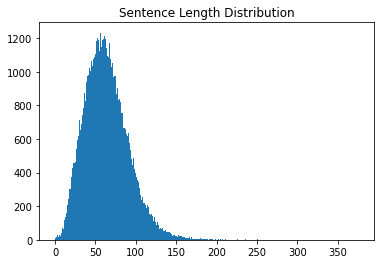

In [6]:
min_len = 999
max_len = 0
sum_len = 0

cleaned_corpus = list(set(raw))  # set를 사용해서 중복을 제거합니다.
print("Data Size:", len(cleaned_corpus))

for sen in cleaned_corpus:
    length = len(sen)
    if min_len > length: min_len = length
    if max_len < length: max_len = length
    sum_len += length

print("문장의 최단 길이:", min_len)
print("문장의 최장 길이:", max_len)
print("문장의 평균 길이:", sum_len // len(cleaned_corpus))

sentence_length = np.zeros((max_len), dtype=int)

for sen in cleaned_corpus:   # 중복이 제거된 코퍼스 기준
    sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

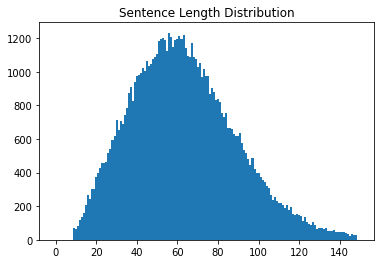

In [7]:
max_len = 150
min_len = 10

# 길이 조건에 맞는 문장만 선택합니다.
filtered_corpus = [s for s in cleaned_corpus if (len(s) < max_len) & (len(s) >= min_len)]

# 분포도를 다시 그려봅니다.
sentence_length = np.zeros((max_len), dtype=int)

for sen in filtered_corpus:
    sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

## 1.2. SentencePiece 토크나이저

- SentencePiece 토크나이저 모델 학습
- 임베딩 진행 (Keras 임베딩 레이어 사용)
- LSTM 모델로 감정 분석
- 다른 임베딩 모델(Word2Vec, FastText, ELMo) 적용하기 (예정)

In [8]:
import sentencepiece as spm
import os

temp_file = os.path.abspath('') + '/data/korean-english-park.train.ko.tmp'

vocab_size = 8000

with open(temp_file, 'w') as f:
    for row in filtered_corpus:   # 이전에 나왔던 정제했던 corpus를 활용해서 진행해야 합니다.
        f.write(str(row) + '\n')

spm.SentencePieceTrainer.Train(
    '--input={} --model_prefix=korean_spm --vocab_size={} --model_type=bpe'.format(temp_file, vocab_size)    
)
#위 Train에서  --model_type = unigram이 디폴트 적용되어 있습니다. --model_type = bpe로 옵션을 주어 변경할 수 있습니다.

!ls -l korean_spm*

sentencepiece_trainer.cc(177) LOG(INFO) Running command: --input=/aiffel/aiffel/_Quests/GoingDeeper/GD_01/data/korean-english-park.train.ko.tmp --model_prefix=korean_spm --vocab_size=8000 --model_type=bpe
sentencepiece_trainer.cc(77) LOG(INFO) Starts training with : 
trainer_spec {
  input: /aiffel/aiffel/_Quests/GoingDeeper/GD_01/data/korean-english-park.train.ko.tmp
  input_format: 
  model_prefix: korean_spm
  model_type: BPE
  vocab_size: 8000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  hard_vocab

-rw-r--r-- 1 root root 371948 Oct 11 07:52 korean_spm.model
-rw-r--r-- 1 root root 117142 Oct 11 07:52 korean_spm.vocab


In [9]:
s = spm.SentencePieceProcessor()
s.Load('korean_spm.model')

"""
매개변수는 공식 코드베이스 참고:
https://github.com/google/sentencepiece/blob/master/src/sentencepiece_processor.h#L474
"""

# SentencePiece를 활용한 sentence -> encoding
tokensIDs = s.EncodeAsIds(input='아버지가방에들어가신다.')
print(tokensIDs)

# SentencePiece를 활용한 sentence -> encoded pieces
print(s.SampleEncodeAsPieces(input='아버지가방에들어가신다.',
                             nbest_size=1,
                             alpha=0.0))

# SentencePiece를 활용한 encoding -> sentence 복원
print(s.DecodeIds(ids=tokensIDs))

[1520, 1154, 6614, 6710, 2644, 6782, 6685, 6687]
['▁아버', '지가', '방에', '들', '어가', '신', '다', '.']
아버지가방에들어가신다.


In [10]:
maxlen=70  # -- mecab 사용 경우와 통일

In [11]:
def sp_tokenize(s: spm.SentencePieceProcessor, dataset: pd.DataFrame, corpus_label: str): 

    tensor = []

    for idx, sen in enumerate(dataset[corpus_label]):  ## 말뭉치에 있는 문장을 모두 인코딩하여 tensor 행렬에 추가
        if type(sen) != str:
            dataset.drop(index=idx, axis='index', inplace=True)  ## 문자열이 아닌 경우 제거 -- 예) 줄바꿈, 결측치
            continue
        tensor.append(s.EncodeAsIds(sen))
        # print(sen)

    with open("./korean_spm.vocab", 'r') as f:
        vocab = f.readlines()

    word_index = {}
    index_word = {}

    for idx, line in enumerate(vocab):
        word = line.split("\t")[0]

        word_index.update({word:idx})
        index_word.update({idx:word})

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor,
                                                           # value=word_index["<PAD>"],  ## 여기서는 <PAD> 토큰 없음
                                                           padding='pre',  ## 노드 상으로는 'post'
                                                           maxlen=maxlen)  ## 노드에서는 없는 인자 -- mecab 사용 경우와 통일
    return tensor, word_index, index_word

// 위에서 주는 패딩을 post 대신 pre로 줬는데, 성능 향상이 실제로 되는지?

In [12]:
enc_sentence_tensor_train, word_to_idx_train, idx_to_word_train = sp_tokenize(s=s,
                                                                              dataset=train_data,
                                                                              corpus_label='document')

enc_sentence_tensor_test, word_to_idx_test, idx_to_word_test = sp_tokenize(s=s,
                                                                           dataset=test_data,
                                                                           corpus_label='document')

In [13]:
print(enc_sentence_tensor_train, f"\n=============={'='*24}")  # 인코딩 시각화
print(s.DecodeIds(ids=enc_sentence_tensor_train[0].tolist()))  # 인코딩의 디코딩 결과 예시

[[   0    0    0 ... 6821 2957 6706]
 [   0    0    0 ...   55 6760 6730]
 [   0    0    0 ... 6942 7063  182]
 ...
 [   0    0    0 ... 1099  394 7248]
 [   0    0    0 ...   35 6785 6733]
 [   0    0    0 ... 4520 4554  350]] 
 ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  아 더빙.. 진짜 짜증나네요 목소리


In [14]:
print(len(enc_sentence_tensor_train), len(train_data['document']), len(train_data['label']))

149995 149995 149995


In [15]:
X_train_sp = enc_sentence_tensor_train
y_train_sp = train_data['label']
X_test_sp = enc_sentence_tensor_test
y_test_sp = test_data['label']

## 1.1.2. Mecab 토크나이저

In [16]:
from konlpy.tag import Mecab
from collections import Counter

class TokenizerMecab:
    tokenizer = Mecab(dicpath='/usr/local/lib/mecab/dic/mecab-ko-dic')
    stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

    def preprocess_sentence(self, batch_data, focus_col, stopword_list):
        batch_data.drop_duplicates(subset=[focus_col], inplace=True)
        batch_data.dropna(how='any', inplace=True)  # Corrected to operate on the passed batch_data

        processed_sentences = []  # Initialize a list to collect processed sentences
        for sentence in batch_data[focus_col]:
            tokens = self.tokenizer.morphs(sentence)  # 토큰화
            tokens = [word for word in tokens if word not in stopword_list]  # 불용어 제거
            processed_sentences.append(tokens)
        return processed_sentences  # Return all processed sentences

    def load_data(self, train_data, test_data, num_words=10000):
        X_train = self.preprocess_sentence(train_data, 'document', self.stopwords)  # Process all training data
        X_test = self.preprocess_sentence(test_data, 'document', self.stopwords)  # Process all test data

        words = np.concatenate(X_train).tolist()
        counter = Counter(words)
        counter = counter.most_common(num_words - 4)
        vocab = ['<PAD>', '', '', ''] + [key for key, _ in counter]
        word_to_index = {word: index for index, word in enumerate(vocab)}
        
        def wordlist_to_indexlist(wordlist):
            return [word_to_index[word] if word in word_to_index else word_to_index[''] for word in wordlist]
        
        X_train = list(map(wordlist_to_indexlist, X_train))
        X_test = list(map(wordlist_to_indexlist, X_test))

        return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
    def __init__(self, train_data, test_data):
        data_ready = self.load_data(train_data, test_data)
        self.X_train, self.y_train, self.X_test, self.y_test, self.word_to_index = data_ready

In [17]:
Mecab = TokenizerMecab(train_data, test_data)

X_train_mc, y_train_mc, X_test_mc, y_test_mc, word_to_index = Mecab.X_train, \
                                                              Mecab.y_train, \
                                                              Mecab.X_test,  \
                                                              Mecab.y_test,  \
                                                              Mecab.word_to_index

In [18]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [19]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

In [20]:
print(index_to_word) # 시각화

{0: '<PAD>', 3: '', 4: '.', 5: '영화', 6: '다', 7: '고', 8: '하', 9: '을', 10: '보', 11: '..', 12: '게', 13: ',', 14: '!', 15: '지', 16: '있', 17: '없', 18: '?', 19: '좋', 20: '나', 21: '었', 22: '만', 23: '는데', 24: '너무', 25: '봤', 26: '적', 27: '안', 28: '정말', 29: '로', 30: '음', 31: '것', 32: '아', 33: '네요', 34: '재밌', 35: '어', 36: '같', 37: '점', 38: '지만', 39: '진짜', 40: '했', 41: '에서', 42: '기', 43: '네', 44: '않', 45: '거', 46: '았', 47: '수', 48: '되', 49: '면', 50: 'ㅋㅋ', 51: '말', 52: '연기', 53: '인', 54: '주', 55: '내', 56: '최고', 57: '~', 58: '평점', 59: '이런', 60: '던', 61: '어요', 62: '할', 63: '왜', 64: '겠', 65: '1', 66: '스토리', 67: '해', 68: '습니다', 69: 'ㅋㅋㅋ', 70: '...', 71: '드라마', 72: '생각', 73: '아니', 74: '더', 75: '그', 76: '싶', 77: '사람', 78: '듯', 79: '때', 80: '감동', 81: '함', 82: '배우', 83: '본', 84: '까지', 85: '뭐', 86: '알', 87: '만들', 88: '내용', 89: '볼', 90: '감독', 91: '보다', 92: '라', 93: '그냥', 94: '재미', 95: '시간', 96: '지루', 97: '중', 98: '재미있', 99: '년', 100: '10', 101: '였', 102: '잼', 103: '사랑', 104: '못', 105: '냐', 106: '재미없', 107: '

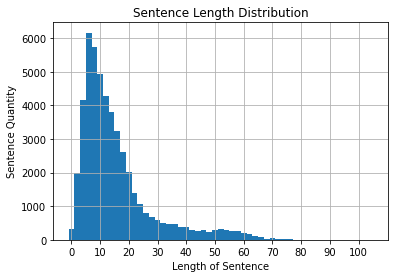

In [21]:
import matplotlib.pyplot as plt
from collections import Counter

def draw_histogram_of_dataset(dataset, type=0):
    # 각 문장의 길이 계산 및 카운트
    length_counts = Counter(len(arr) for arr in dataset)
    
    min_length = min(length_counts.keys())
    max_length = max(length_counts.keys())
    
    if type != 0:  # -- 이후 실험을 위한 조건문
        if min_length == max_length:
            print("모든 문장의 길이(구성 요소 개수) 동일")
            return
    
#     # 분포 출력
#     print("[ 문장의 길이 분포 ] (길이: 개수)")
#     for length, count in sorted(length_counts.items()):
#         print(f"{length}: {count}")
    
    # 히스토그램 그리기
    # 최소 길이와 최대 길이를 기준으로 적절한 bin 사이즈 설정
    bin_size = (max_length - min_length) // 50  # 50개의 구간으로 나누어 시각화

    plt.hist(length_counts.keys(), weights=length_counts.values(), bins=range(min_length, max_length + bin_size, bin_size), align='left')
    plt.xlabel('Length of Sentence')
    plt.ylabel('Sentence Quantity')
    plt.title('Sentence Length Distribution')
    plt.xticks(range(min_length, max_length + 1, bin_size * 5))  # x축 눈금을 적절히 조절
    plt.grid(True)
    plt.show()

draw_histogram_of_dataset(dataset=X_test_mc)

In [22]:
length_counts = Counter(len(arr) for arr in X_test_mc)
print(max(length_counts.values()), max(length_counts.items()))

3117 (105, 1)


In [23]:
maxlen=70  # 위 분포에 따라 길이 70 이하의 문장이 주로 존재하기에, 문장 길이를 70으로 제한.

In [24]:
print(len(X_test_mc))

49157


In [25]:
X_train_mc = tf.keras.preprocessing.sequence.pad_sequences(X_train_mc,
                                                           value=word_to_index["<PAD>"],
                                                           padding='pre',
                                                           maxlen=maxlen)

X_test_mc = tf.keras.preprocessing.sequence.pad_sequences(X_test_mc,
                                                          value=word_to_index["<PAD>"],
                                                          padding='pre',
                                                          maxlen=maxlen)

## 1.2. Embedding

In [26]:
vocab_size = len(word_to_index)
word_vector_dim = 10  # 워드 벡터 차원 (실험 요)

embedding = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=word_vector_dim, mask_zero=True)

embedding_with_mecab_output = embedding(X_train_mc)
print(embedding_with_mecab_output)

tf.Tensor(
[[[ 0.00825454  0.0460835   0.0484415  ...  0.00895047 -0.02063727
    0.04187718]
  [ 0.00825454  0.0460835   0.0484415  ...  0.00895047 -0.02063727
    0.04187718]
  [ 0.00825454  0.0460835   0.0484415  ...  0.00895047 -0.02063727
    0.04187718]
  ...
  [-0.04179449  0.03938716 -0.00648223 ... -0.04943047  0.04822682
   -0.00106356]
  [ 0.00299792  0.03264521 -0.04129596 ... -0.01909579  0.04952457
   -0.02838838]
  [ 0.04671672  0.0273826   0.01199583 ...  0.04659296  0.0222047
    0.02977904]]

 [[ 0.00825454  0.0460835   0.0484415  ...  0.00895047 -0.02063727
    0.04187718]
  [ 0.00825454  0.0460835   0.0484415  ...  0.00895047 -0.02063727
    0.04187718]
  [ 0.00825454  0.0460835   0.0484415  ...  0.00895047 -0.02063727
    0.04187718]
  ...
  [ 0.04792165  0.042541   -0.04933455 ... -0.04399408  0.0281125
    0.0332864 ]
  [ 0.02494011  0.04968781  0.02603414 ... -0.01029897  0.04267223
    0.00733488]
  [-0.0404424  -0.0398842  -0.04142274 ... -0.02680241 -0.006544

## 1.3. Modeling

감정 분석을 추론하는 모델은 이번 실험에서 통제 변인이다. 이에 따라 한가지의 모델만 컴파일한다.  
LSTM 기반 모델을 사용한다.

In [27]:
model_lstm = tf.keras.Sequential()
model_lstm.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_lstm.add(tf.keras.layers.LSTM(8))
model_lstm.add(tf.keras.layers.Dense(8, activation='relu'))
model_lstm.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model_lstm.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 10)          99980     
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 608       
_________________________________________________________________
dense (Dense)                (None, 8)                 72        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 100,669
Trainable params: 100,669
Non-trainable params: 0
_________________________________________________________________


In [28]:
from tensorflow_addons.metrics import F1Score

model_lstm.compile(optimizer='adam',
                   loss='binary_crossentropy',
                   metrics=[
                       'accuracy',
                       # F1Score(name='f1_score', num_classes=2),
                   ])

## 1.4. Training

본격적인 모델 훈련을 들어가기에 앞서서, 결과 시각화 함수를 포함하여 두 가지 경우에 동일하게 적용해야 하는 사항들을 미리 정의한다.

In [34]:
# Define function for visualization

import matplotlib.pyplot as plt

def plot_loss_and_metric(fit_history: tf.keras.callbacks.History):
    history_dict = fit_history.history
    
    acc = history_dict['accuracy']
    val_acc = history_dict['val_accuracy']
#     f1_score = history_dict['f1_score']
#     val_f1_score = history_dict['val_f1_score']
    loss = history_dict['loss']
    val_loss = history_dict['val_loss']
    
    epochs = range(1, len(acc) + 1)

    # "bo"는 "파란색 점"입니다
    plt.plot(epochs, loss, 'bo', label='Training loss')
    # b는 "파란 실선"입니다
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()
    
    plt.clf()   # 그림 초기화

    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()
    
#     plt.clf()   # 그림 초기화

#     plt.plot(epochs, f1_score, 'bo', label='Training F1-score')
#     plt.plot(epochs, val_f1_score, 'b', label='Validation F1-score')
#     plt.title('Training and validation F1-score')
#     plt.xlabel('Epochs')
#     plt.ylabel('F1-score')
#     plt.legend()

#     plt.show()

In [35]:
common_batch_size = 512
common_epochs = 30
val_data_mc = (X_test_mc, y_test_mc)
val_data_sp = (X_test_sp, y_test_sp)

### 1.4.1. LSTM with SentencePiece

In [36]:
history_lstm_with_sentencepiece = model_lstm.fit(X_train_sp,
                                                 y_train_sp,
                                                 epochs=common_epochs,
                                                 batch_size=common_batch_size,
                                                 validation_data=val_data_sp,
                                                 verbose=1)

Epoch 1/30
293/293 [==============================] - 2s 7ms/step - loss: 0.2481 - accuracy: 0.8966 - val_loss: 0.4726 - val_accuracy: 0.8191
Epoch 2/30
293/293 [==============================] - 2s 6ms/step - loss: 0.2417 - accuracy: 0.8990 - val_loss: 0.4870 - val_accuracy: 0.8202
Epoch 3/30
293/293 [==============================] - 2s 6ms/step - loss: 0.2401 - accuracy: 0.9006 - val_loss: 0.4921 - val_accuracy: 0.8200
Epoch 4/30
293/293 [==============================] - 2s 6ms/step - loss: 0.2351 - accuracy: 0.9028 - val_loss: 0.4924 - val_accuracy: 0.8193
Epoch 5/30
293/293 [==============================] - 2s 6ms/step - loss: 0.2328 - accuracy: 0.9041 - val_loss: 0.4956 - val_accuracy: 0.8190
Epoch 6/30
293/293 [==============================] - 2s 7ms/step - loss: 0.2305 - accuracy: 0.9051 - val_loss: 0.5066 - val_accuracy: 0.8182
Epoch 7/30
293/293 [==============================] - 2s 6ms/step - loss: 0.2309 - accuracy: 0.9051 - val_loss: 0.4840 - val_accuracy: 0.8142
Epoch 

In [37]:
results = model_lstm.evaluate(X_test_sp,  y_test_sp, verbose=2)
print(results)

1563/1563 - 4s - loss: 0.6058 - accuracy: 0.8087
[0.6058261394500732, 0.8086684942245483]


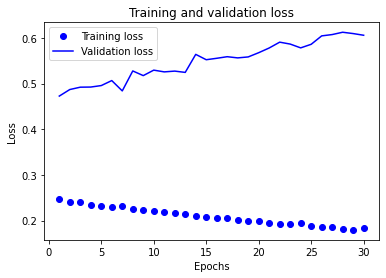

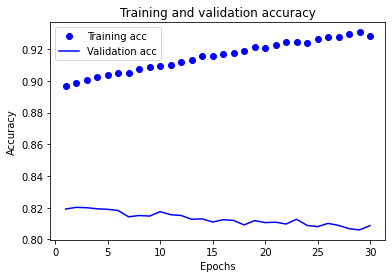

In [38]:
plot_loss_and_metric(fit_history=history_lstm_with_sentencepiece)

### 1.4.2. LSTM with Mecab

In [39]:
epochs=20

history_lstm_with_mecab = model_lstm.fit(X_train_mc,
                                         y_train_mc,
                                         epochs=common_epochs,
                                         batch_size=common_batch_size,
                                         validation_data=val_data_mc,
                                         verbose=1)

Epoch 1/30
286/286 [==============================] - 2s 7ms/step - loss: 0.6582 - accuracy: 0.6684 - val_loss: 0.5030 - val_accuracy: 0.7572
Epoch 2/30
286/286 [==============================] - 2s 7ms/step - loss: 0.4348 - accuracy: 0.7987 - val_loss: 0.4081 - val_accuracy: 0.8157
Epoch 3/30
286/286 [==============================] - 2s 7ms/step - loss: 0.3638 - accuracy: 0.8403 - val_loss: 0.3782 - val_accuracy: 0.8320
Epoch 4/30
286/286 [==============================] - 2s 7ms/step - loss: 0.3339 - accuracy: 0.8562 - val_loss: 0.3672 - val_accuracy: 0.8395
Epoch 5/30
286/286 [==============================] - 2s 7ms/step - loss: 0.3164 - accuracy: 0.8651 - val_loss: 0.3617 - val_accuracy: 0.8431
Epoch 6/30
286/286 [==============================] - 2s 7ms/step - loss: 0.3049 - accuracy: 0.8713 - val_loss: 0.3590 - val_accuracy: 0.8444
Epoch 7/30
286/286 [==============================] - 2s 6ms/step - loss: 0.2957 - accuracy: 0.8761 - val_loss: 0.3578 - val_accuracy: 0.8453
Epoch 

In [40]:
results = model_lstm.evaluate(X_test_mc,  y_test_mc, verbose=2)
print(results)

1537/1537 - 3s - loss: 0.5502 - accuracy: 0.8338
[0.550193190574646, 0.8337571620941162]


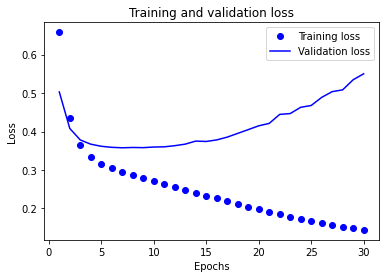

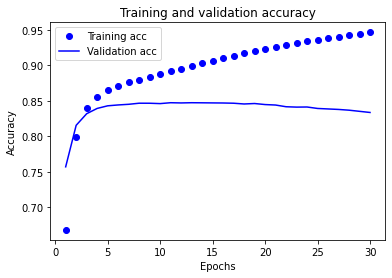

In [41]:
plot_loss_and_metric(fit_history=history_lstm_with_mecab)

- **통제 변인**
  - 패딩 기법
  - 임베딩 기법
  - 감정 분석 모델


| S/N |      토큰화     | 별도의 불용어 제거 | 패딩 기법 |        임베딩 기법        | 감정 분석 모델 | F1-score | accuracy | precision | recall |
| :-: | :-----------: | :------------: | :-----: | :--------------------: | :---------: | :------: | :------: | :-------: | :----: |
|  1  |     Mecab     |        O       |   pre   |  Keras Embedding Layer |     LSTM    |          |          |           |        |
|  2  | SentencePiece |        X       |   pre   |  Keras Embedding Layer |     LSTM    |          |          |           |        |


|   토큰화 방식    |  -  |
| :-----------: | :-: |
| SentencePiece |  -  |
|     Mecab     |  -  |

# 회고

> 이 프로젝트를 통해 자연어 처리를 위한 가장 기본적인 배경을 꼼꼼히 살펴볼 수 있었다.  
> 문장을 조각내는 '토큰화', 이에 기계가 의미를 파악할 수 있도록 도와주는 '임베딩', 그리고 최종적으로 최종 모델이 원하는 결과물을 내주는 과정을 이해할 수 있었다.  
> 